In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord('12 01 36.81 -65 08 49.22', unit=(u.hourangle, u.deg))

In [104]:
def gaussian_psf_extraction(image, pix2arcsec, beam_size, pos):
    import photutils as phot
    
    # Gaussian sigma in pixel unit
    psf = phot.psf.GaussianPSF(beam_size/pix2arcsec)
    flux_gaussian = phot.psf.psf_photometry(image, [pos], psf)
    
    return flux_gaussian

In [105]:
data = fits.open('/Users/yaolun/bhr71/data/photometry/herschel_photometry/1342224922/browseProduct/blue_JScanam_map/hpacs_25HPPJSMAPB_blue_1202_m6509_00_v1.0_1434550765178.fits')

5.88584110241 -0.0210900464874
76.1288327447


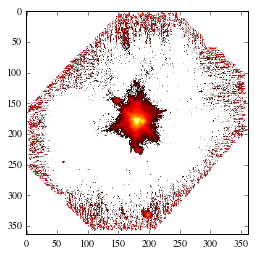

In [122]:
from matplotlib.colors import LogNorm
print data[1].data.max(), data[1].data.min()
plt.imshow(data[1].data, cmap='hot', norm=LogNorm(vmin=0.0001,vmax=6))
print np.sum(data[1].data)
test = np.where(data[1].data < 0, data[1].data, 0)

In [123]:
print np.sum(test)

-77.7792059107


## Get the pixel coordinates of the source from the physical coordinates

In [106]:
w = wcs.WCS(data[1].header)
data_pixcoord = w.wcs_world2pix(np.array([[c.ra.degree, c.dec.degree]]),1)[0]

In [107]:
import photutils as phot
psf = phot.psf.GaussianPSF(13.5/pix2arcsec)

## Get the pixel to physical conversion factor

In [108]:
cdelt1 = data[1].header['CDELT1']
cdelt2 = data[1].header['CDELT2']
if abs(cdelt1) != abs(cdelt2):
    print 'pixel scales are different in two axis. %f and %f' % (cdelt1, cdelt2)
pix2arcsec = abs(cdelt1)*3600

In [109]:
flux = gaussian_psf_extraction(data[1].data, pix2arcsec, 13.5, data_pixcoord)

In [110]:
print flux

[ 0.4925131]


In [111]:
sample = np.empty_like(data[1].data) + 1
flux_sample = gaussian_psf_extraction(sample, pix2arcsec, 13.5, data_pixcoord)

In [112]:
print flux_sample

[ 1.99648593]


In [83]:
def Gaussian_anywhere(ra_offset, dec_offset, radius, size=701., phys_size=70.):
    # Create a 2-D cartian grid for mapping 2-D Gaussian
    def gauss2d(x, y, sigmax, sigmay=None):
        # sigmax needs to be in pixel coordinates
        if sigmay == None:
            sigmay = sigmax
        return 1/(2*np.pi*sigmax*sigmay) * np.exp( -(x**2/2./sigmax**2 + y**2/2./sigmay**2) )
    
    grid_x, grid_y = np.meshgrid(np.linspace(0,size-1,size), np.linspace(0,size-1,size))
    grid_x = grid_x - (size-1)/2.
    grid_y = grid_y - (size-1)/2.
    grid_gauss2d = gauss2d(grid_x,grid_y, sigmax=(size-1)/phys_size*13.5)
    dA = ((1/((size-1)/2.))*phys_size)**2

    # convert from physcial coordinates to pixel coordinates
    x = (ra_offset-phys_size/2.) * (size-1)/2./(phys_size/2.) + (size-1)/2.
    y = (dec_offset-phys_size/2.) * (size-1)/2./(phys_size/2.) + (size-1)/2.
    r_pix = radius * (size-1)/phys_size
    grid_dist = ((grid_x-x)**2+(grid_y-y)**2)**0.5
    gauss2d_mask = np.where(grid_dist<=r_pix, grid_gauss2d,0)
    
    return np.sum(gauss2d_mask)/grid_gauss2d.max()
Gaussian_anywhere(0,0,13.5, size=364., phys_size=582.4)

171.74018812771922

In [29]:
import photutils as phot
aperture = phot.CircularAperture(data_pixcoord, r=12.25)
phot_table = phot.aperture_photometry(data[1].data, aperture)
print phot_table

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
124.373388553 178.684952869 180.631995397
